# PhishGuard: Real-Time Phishing Detection with XGBoost


This notebook implements a phishing detection system using XGBoost, with features extracted from URLs, source code, and webpage screenshots. The project includes:

- Data preprocessing and feature extraction (from `feature_extract.py`)
- Training and tuning Logistic Regression and XGBoost models
- Evaluating performance on balanced and imbalanced test sets
- Visualizing results with confusion matrices, precision-recall curves, ROC curves, and feature importance

## Imports

This cell imports all necessary libraries for data handling, machine learning, evaluation, and visualization.

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
import math
np.random.seed(42)

## Data Loading and Preprocessing

This cell loads the dataset from `features.csv`, splits it into features (X) and labels (y), performs a train-test split, and scales the features using StandardScaler.
- **Inputs**: `features.csv` (output from `feature_extract.py`)
- **Outputs**: Training and test sets (X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
# Load and preprocess data
df = pd.read_csv('features.csv')
X = df.drop(['label'], axis=1)
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
df.value_counts('label')

label
0    1282198
1      82685
Name: count, dtype: int64

In [16]:
df.shape

(1364883, 9)

## Train Logistic Regression Model

This cell trains a Logistic Regression model as a baseline, using class weights to handle imbalance.
- **Inputs**: `X_train_scaled`, `y_train`
- **Outputs**: Trained `lr_model`

In [3]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Train and Tune XGBoost Model

This cell trains an XGBoost model, and performs hyperparameter tuning using GridSearchCV to optimize recall.
- **Inputs**: `X_train_scaled`, `y_train`
- **Outputs**: Trained `best_xgb` model, best hyperparameters

In [5]:
# Train XGBoost
xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    eval_metric='logloss',
    random_state=42
)

# Hyperparameter tuning with F1-score
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)  
best_xgb = grid_search.best_estimator_
print(f"Best XGBoost Params: {grid_search.best_params_}")


Best XGBoost Params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}


## Evaluate Models on Balanced Test Set

This cell evaluates both models on the balanced test set using precision, recall, and F1-score.
- **Inputs**: `X_test_scaled`, `y_test`, `lr_model`, `best_xgb`
- **Outputs**: Classification reports for both models

In [5]:
# Evaluate on balanced test set
lr_preds = lr_model.predict(X_test_scaled)
xgb_preds = best_xgb.predict(X_test_scaled)
print("Logistic Regression Performance (Balanced Test Set):")
print(classification_report(y_test, lr_preds))
print("XGBoost Performance (Balanced Test Set):")
print(classification_report(y_test, xgb_preds))

Logistic Regression Performance (Balanced Test Set):
              precision    recall  f1-score   support

           0       0.77      0.43      0.55      1739
           1       0.89      0.97      0.93      8482

    accuracy                           0.88     10221
   macro avg       0.83      0.70      0.74     10221
weighted avg       0.87      0.88      0.87     10221

XGBoost Performance (Balanced Test Set):
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1739
           1       0.96      0.97      0.96      8482

    accuracy                           0.94     10221
   macro avg       0.90      0.88      0.89     10221
weighted avg       0.94      0.94      0.94     10221



## Create and Evaluate on Imbalanced Test Set

This cell creates an imbalanced test set (10% phishing, 90% benign) to simulate real-world conditions and evaluates both models on it.
- **Inputs**: `df`, `scaler`, `lr_model`, `best_xgb`
- **Outputs**: Classification reports for both models on the imbalanced test set

In [6]:
# Create an extreme imbalanced test set (1% phishing, 99% benign)
phishing_test = df[df['label'] == 1].sample(frac=0.01, random_state=42)
benign_test = df[df['label'] == 0].sample(frac=0.99, random_state=42)
imbalanced_test = pd.concat([phishing_test, benign_test])
X_imbalanced = imbalanced_test.drop(['label'], axis=1)
y_imbalanced = imbalanced_test['label']
X_imbalanced_scaled = scaler.transform(X_imbalanced)

# Evaluate on imbalanced test set
lr_preds_imbalanced = lr_model.predict(X_imbalanced_scaled)
xgb_preds_imbalanced = best_xgb.predict(X_imbalanced_scaled)
print("Logistic Regression Performance (Extreme Imbalanced Test Set):")
print(classification_report(y_imbalanced, lr_preds_imbalanced))
print("XGBoost Performance (Extreme Imbalanced Test Set):")
print(classification_report(y_imbalanced, xgb_preds_imbalanced))

Logistic Regression Performance (Extreme Imbalanced Test Set):
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      8610
           1       0.08      0.96      0.14       424

    accuracy                           0.46      9034
   macro avg       0.54      0.70      0.38      9034
weighted avg       0.95      0.46      0.59      9034

XGBoost Performance (Extreme Imbalanced Test Set):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      8610
           1       0.25      0.98      0.40       424

    accuracy                           0.86      9034
   macro avg       0.63      0.92      0.66      9034
weighted avg       0.96      0.86      0.90      9034



## Visualize Confusion Matrices

This cell plots confusion matrices for both models on the balanced test set to visualize true positives, false positives, true negatives, and false negatives.
- **Inputs**: `y_test`, `lr_preds`, `xgb_preds`
- **Outputs**: Confusion matrix plots

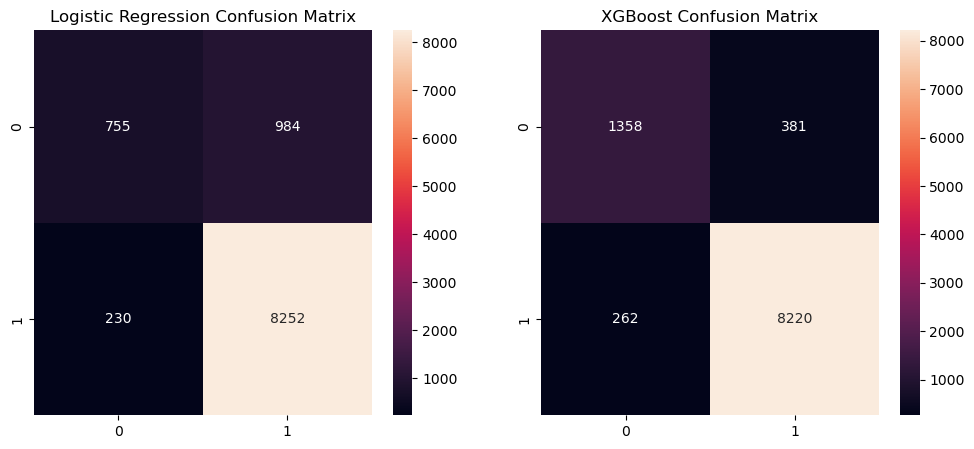

In [7]:
# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt='d', ax=ax1)
ax1.set_title('Logistic Regression Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', ax=ax2)
ax2.set_title('XGBoost Confusion Matrix')
plt.show()

## Precision-Recall Curve with Baseline

This cell plots the precision-recall curve for XGBoost on the balanced test set, with a random classifier baseline for comparison.
- **Inputs**: `y_test`, `xgb_probs`
- **Outputs**: Precision-recall curve plot

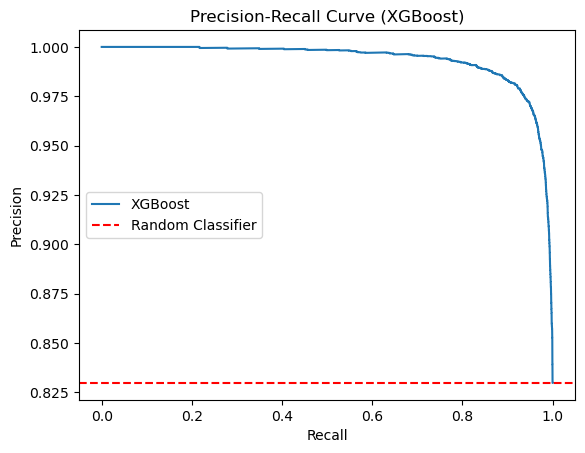

In [8]:
# Precision-Recall Curve with baseline
xgb_probs = best_xgb.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)
plt.plot(recall, precision, label='XGBoost')
plt.axhline(y=sum(y_test) / len(y_test), color='r', linestyle='--', label='Random Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.show()

## Feature Importance Analysis

This cell analyzes and visualizes the feature importance for the XGBoost model to understand which features contribute most to phishing detection.
- **Inputs**: `X`, `best_xgb`
- **Outputs**: Feature importance table and bar plot

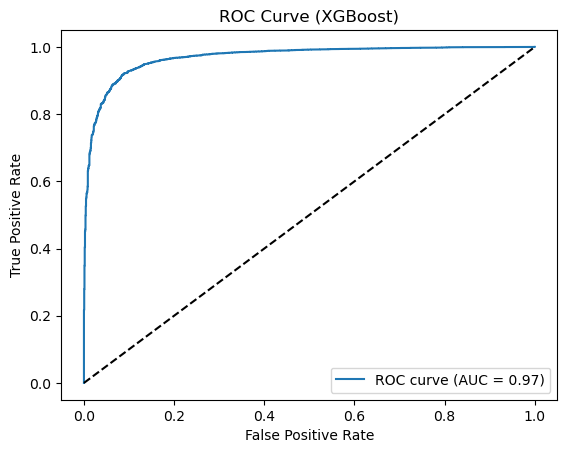

In [9]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend()
plt.show()

## Feature Importance Analysis

This cell analyzes and visualizes the feature importance for the XGBoost model to understand which features contribute most to phishing detection.
- **Inputs**: `X`, `best_xgb`
- **Outputs**: Feature importance table and bar plot

Feature Importance:
                   feature  importance
6      num_external_links    0.296316
5  has_suspicious_keyword    0.207718
2               has_https    0.111945
4       num_special_chars    0.087856
1          num_subdomains    0.085818
7             num_scripts    0.077561
0              url_length    0.070057
3             num_hyphens    0.062729


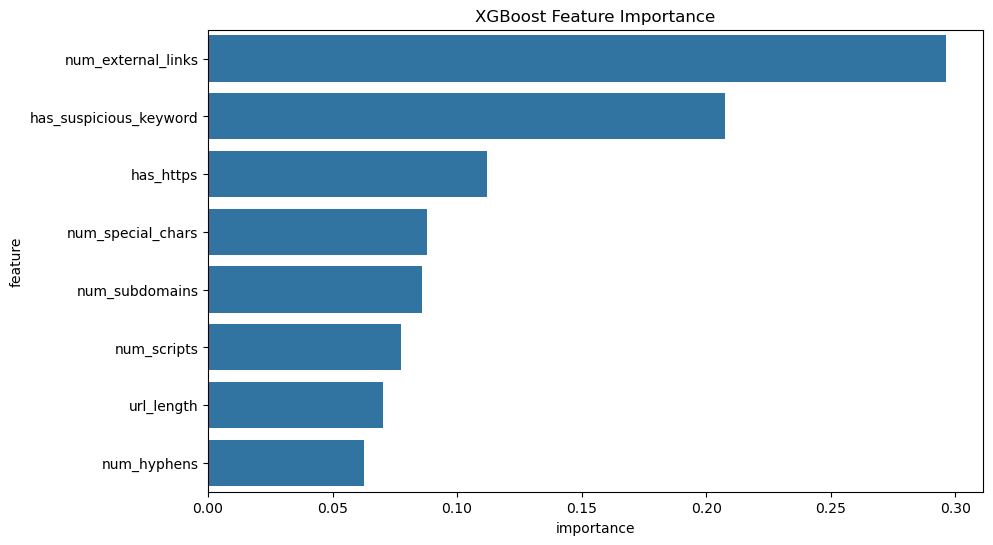

In [10]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)
print("Feature Importance:\n", feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.show()

## Automated Threshold Tuning and Adjusted Evaluation

This cell performs automated threshold tuning to maximize F1-score and re-evaluates XGBoost with the optimal threshold on the balanced test set.
- **Inputs**: `y_test`, `xgb_probs`, `precision`, `recall`, `thresholds`
- **Outputs**: Optimal threshold, adjusted classification report

In [11]:
# Automated threshold tuning
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Adjust predictions with optimal threshold
xgb_preds_adjusted = (xgb_probs >= optimal_threshold).astype(int)
print("XGBoost Performance (Adjusted Threshold):")
print(classification_report(y_test, xgb_preds_adjusted))

Optimal Threshold: 0.5431044697761536
XGBoost Performance (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1739
           1       0.96      0.97      0.96      8482

    accuracy                           0.94     10221
   macro avg       0.90      0.88      0.89     10221
weighted avg       0.94      0.94      0.94     10221

